In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib
# matplotlib.use('agg')
# matplotlib.use('TkAgg')
# matplotlib.use('qtagg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import *
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from math import *
#import pandas as pd

from scipy import interpolate
from scipy.optimize import curve_fit 

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.coordinates import SkyCoord, ICRS, Galactic
# import astropy.units as u
import astropy.units as units
import astropy.coordinates as coord
#from matplotlib.colors import LogNorm

# from mpl_toolkits.axes_grid1 import make_axes_locatable
# #import matplotlib.ticker as mtick


import os
#%matplotlib widget
import seaborn as sns
import os, sys


# from astropy.io import ascii
# from astropy.coordinates import galactocentric_frame_defaults

import sklearn
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

from scipy import interpolate

import random
from scipy import integrate


gcolor = ['c','blue','g','r','orange', 'green','cyan']

In [3]:
import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util
import ppxf.sps_util as lib
import sys,glob
from pathlib import Path

from ppxf.ppxf import ppxf, robust_sigma

from vorbin.voronoi_2d_binning import voronoi_2d_binning
from plotbin.display_bins import display_bins

from tqdm import tqdm  

# Global Setting

## Galaxy information

In [4]:
c = 299792.458  # spped of light [km/s]

galaxy_name = 'VCC_1588'
spectrum_filename = 'VCC1588_stack.fits'
spectrum_z = 0.0042

## basic fitting parameters

In [5]:
lam_range_temp = [4800, 5300]
redshift = spectrum_z           # redshift from
objfile = Path('./../Ori_Data/'+spectrum_filename)

In [6]:
# templates

sps_name = 'emiles'
ppxf_dir = Path(lib.__file__).parent
basename = f"spectra_{sps_name}_9.0.npz"
filename = ppxf_dir / 'sps_models' / basename

In [7]:
# vel_s = c * spectrum_z
vel_s = 0
vel_dis_s = 40 # Set the dis v = 40 km/s

# Data Input

In [8]:
## Code from example

class read_data_cube:
    def __init__(self, filename, lam_range, redshift):
        """Read data cube, de-redshift, log rebin and compute coordinates of each spaxel."""

        self.read_fits_file(filename)

        # Only use the specified rest-frame wavelength range
        wave = self.wave/(1 + redshift)      # de-redshift the spectrum
        w = (wave > lam_range[0]) & (wave < lam_range[1])
        wave = wave[w]
        cube = self.cube[w, ...]
        cubevar = self.cubevar[w, ...]

        signal = np.nanmedian(cube, 0)
        noise = np.sqrt(np.nanmedian(cubevar, 0))

        # Create coordinates centred on the brightest spaxel
        jm = np.argmax(signal)
        row, col = map(np.ravel, np.indices(cube.shape[-2:]))
        x = (col - col[jm])*self.pixsize_x
        y = (row - row[jm])*self.pixsize_y

        # Transform cube into 2-dim array of spectra
        npix = cube.shape[0]
        spectra = cube.reshape(npix, -1)        # create array of spectra [npix, nx*ny]
        variance = cubevar.reshape(npix, -1)    # create array of variance [npix, nx*ny]

        c = 299792.458  # speed of light in km/s
        velscale = np.min(c*np.diff(np.log(wave)))  # Preserve smallest velocity step
        lam_range_temp = [np.min(wave), np.max(wave)]
        spectra, ln_lam_gal, velscale = util.log_rebin(lam_range_temp, spectra, velscale=velscale)

        # Coordinates and spectra only for spaxels with enough signal
        self.spectra = spectra
        self.variance = variance
        self.x = x
        self.y = y
        self.signal = signal.ravel()
        self.noise = noise.ravel()

        self.col = col + 1   # start counting from 1
        self.row = row + 1
        self.velscale = velscale
        self.ln_lam_gal = ln_lam_gal
        self.fwhm_gal = self.fwhm_gal/(1 + redshift)

        self.velfield = np.ndarray(shape=self.cube.shape[1:3])
        self.sigfield = np.ndarray(shape=self.cube.shape[1:3])

        # self.CD1_1 = self.CD1_1
        # self.CD1_2 = self.CD1_2
        # self.CD2_1 = self.CD2_1
        # self.CD2_2 = self.CD2_2
        # self.CRVAL1 = self.CRVAL1
        # self.CRVAL2 = self.CRVAL2

###############################################################################

    def read_fits_file(self, filename):
        """
        Read MUSE cube, noise, wavelength, spectral FWHM and pixel size.

        It must return the cube and cuberr as (npix, nx, ny) and wave as (npix,)

        IMPORTANT: This is not a general function! Its details depend on the
        way the data were stored in the FITS file and the available keywords in
        the FITS header. One may have to adapt the function to properly read
        the FITS file under analysis.                
        """

        Cut_LHS = 50
        Cut_RHS = 120

        hdu = fits.open(filename)
        head = hdu[0].header
        # cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:] * (10 ** 18)
        cube = hdu[0].data[Cut_LHS:-Cut_RHS,:,:]
        # cube = hdu[0].data * (10 ** 18)
        cubevar = np.empty_like(cube)  # This file contains no errors

        # Only use the specified rest-frame wavelength range
        wave = head['CRVAL3'] + head['CD3_3']*np.arange(cube.shape[0]) + head['CD3_3']*Cut_LHS

        self.cube = cube
        self.cubevar = cubevar
        self.wave = wave
        
        # self.fwhm_gal = 2.62  # Median FWHM = 2.62Å. Range: 2.51--2.88 (ESO instrument manual). 
        self.fwhm_gal = 1
        # self.pixsize = abs(head["CDELT1"])*3600    # 0.2"
        self.pixsize_x = abs(np.sqrt((head['CD1_1'])**2+(head['CD2_1'])**2))*3600
        self.pixsize_y = abs(np.sqrt((head['CD1_2'])**2+(head['CD2_2'])**2))*3600

        self.CD1_1 = head['CD1_1']
        self.CD1_2 = head['CD1_2']
        self.CD2_1 = head['CD2_1']
        self.CD2_2 = head['CD2_2']
        self.CRVAL1 = head['CRVAL1']
        self.CRVAL2 = head['CRVAL2']

In [9]:
Galaxy_info = read_data_cube(objfile, lam_range_temp, redshift)

# Fitting

## Parameters pre-set

In [10]:
FWHM_gal = None   # set this to None to skip templates broadening
sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal, norm_range=[4800, 5300])
# sps = lib.sps_lib(filename, Galaxy_info.velscale, FWHM_gal)

In [11]:
npix, *reg_dim = sps.templates.shape
sps.templates = sps.templates.reshape(npix, -1)
sps.templates /= np.median(sps.templates) # Normalizes stellar templates by a scalar
regul_err = 0.01 # Desired regularization error

lam_range_temp = np.exp(sps.ln_lam_temp[[0, -1]])
mask0 = util.determine_mask(Galaxy_info.ln_lam_gal, lam_range_temp, width=1000)
# nbins = np.unique(bin_num).size
# velbin, sigbin, lg_age_bin, metalbin, nspax = np.zeros((5, nbins))
# optimal_templates = np.empty((npix, nbins))
lam_gal = np.exp(Galaxy_info.ln_lam_gal)

## FTF (First time fitting)

In [12]:
def Cube_sol(Galaxy_cube, redshift):
    
    plt.figure(figsize=(16, 3))
    ##-----------------------------------------------
    galaxies = np.ndarray(shape= (Galaxy_cube.spectra[:,0].shape[0],Galaxy_cube.cube.shape[1],Galaxy_cube.cube.shape[2]))
    # print(Galaxy_cube.cube.shape)
    for i in range(Galaxy_cube.cube.shape[1]):
        for j in range(Galaxy_cube.cube.shape[2]):
            # galaxy,logLam1,velscale = util.log_rebin(np.array([np.min(Galaxy_cube.wave), np.max(Galaxy_cube.wave)]),Galaxy_cube.cube[:,i,j])
            # galaxy = galaxy/np.median(galaxy)

            galaxies[:,i,j] = Galaxy_cube.spectra[:,i*max(Galaxy_cube.col)+j]
    # plt.plot(galaxies[:,10,20])

    # logLam10 = logLam1[:]
    # logLam1 = logLam10[200:-200]

    velscale_ratio = 2
    velscale = Galaxy_cube.velscale

    velfield = np.ndarray(shape=galaxies.shape[1:3])+np.nan
    sigfield = np.ndarray(shape=galaxies.shape[1:3])+np.nan
    tempnum = np.ndarray(shape=galaxies.shape[1:3])
    Bestfitfield = np.ndarray(shape=galaxies.shape)

    optimal_templates = np.ndarray(shape=(npix,galaxies.shape[1],galaxies.shape[2]))
    # pp_field = [[None]*Galaxy_cube.cube.shape[2]]*Galaxy_cube.cube.shape[1]
    # print(pp_field[0][1])

    for i in tqdm(range(galaxies.shape[1])):
        for j in range(galaxies.shape[2]):
            # if(i == 11 and j == 43):                 # -------------------------- Here is the test sentence -------------------------- Here is the test sentence
                plot_TF = True if (i == 11 and j == 43) else False
                tmpgalaxy = galaxies[:,i,j]
                noise = np.full_like(tmpgalaxy,0.1)
                noise = np.ones_like(tmpgalaxy)
                if np.count_nonzero(tmpgalaxy) > 50:
                    pp = ppxf(sps.templates, tmpgalaxy, noise, velscale, [vel_s, vel_dis_s],
                            plot=plot_TF, mask=mask0, lam=lam_gal, lam_temp=sps.lam_temp, quiet=not plot_TF)
                    # pp_field[i][j]=pp
                    Bestfitfield[:,i,j]=pp.bestfit

                    pp.optimal_template = sps.templates.reshape(sps.templates.shape[0], -1) @ pp.weights
                    optimal_templates[:,i,j] = pp.optimal_template
                    velfield[i,j] = pp.sol[0]
                    sigfield[i,j] = pp.sol[1]
                    weights = pp.weights
                    indwt = np.where(weights == np.max(weights))[0]
                    tempnum[i,j] = indwt[0]

    # return velfield, sigfield, pp_field
    return velfield, sigfield, Bestfitfield, optimal_templates

  0%|          | 0/23 [00:00<?, ?it/s]c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\capfit\capfit.py:811: RuntimeWarning: invalid value encountered in scalar divide
  ratio = actred/prered
 48%|████▊     | 11/23 [04:31<04:47, 23.95s/it]

 Best Fit:       Vel     sigma
 comp.  0:        35        11
chi2/DOF: 4.108e-35; DOF: 1696; degree = 4; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 5/150


100%|██████████| 23/23 [09:59<00:00, 26.05s/it]


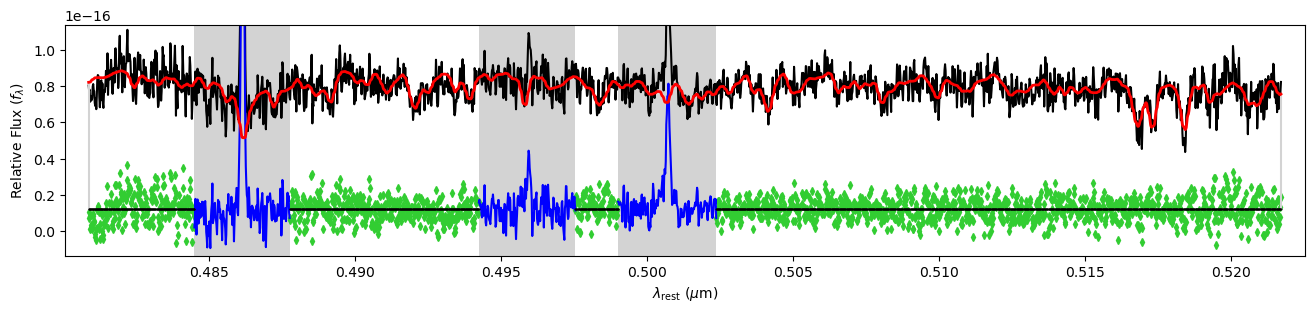

In [13]:
velfield, sigfield, Bestfitfield, optimal_templates = Cube_sol(Galaxy_info, redshift)

In [14]:
Index_Wave = pd.DataFrame({
        'Index':['H_beta','Fe_5015','Mg_b','Fe_5270','Fe_5270_s'],
        'BPC_range':[[4827.875,4847.875],[4946.500,4977.750],[5142.625,5161.375],[5233.150,5248.150],[5233.000,5250.000]],
        'CBP_range':[[4847.875,4876.625],[4977.750,5054.000],[5160.125,5192.625],[5245.650,5285.650],[5256.500,5278.500]],
        'RPC_range':[[4876.625,4891.625],[5054.000,5065.250],[5191.375,5206.375],[5285.650,5318.150],[5285.500,5308.000]]
})

In [15]:
Index_use = [0,1,2,4]

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\2263627391.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
c:\ProgramData\Anaconda3\envs\Ast_Base\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


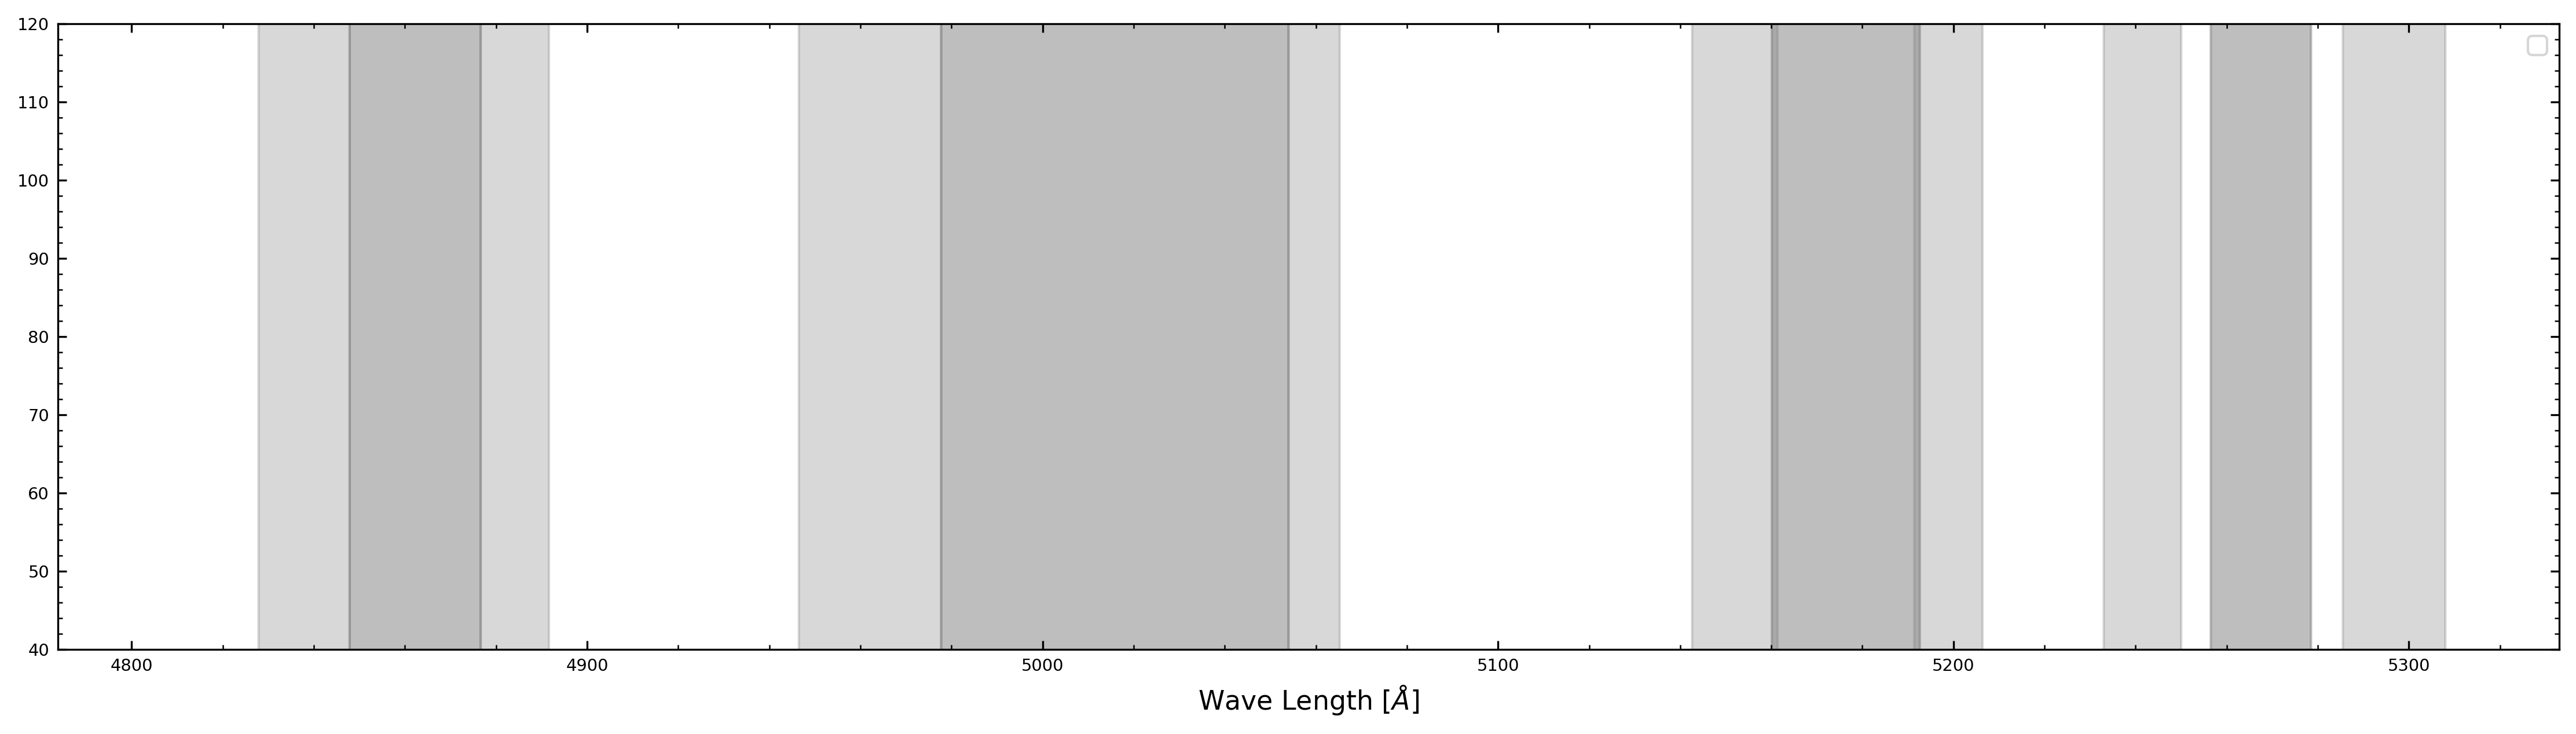

In [16]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,4), dpi=300, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.95, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

ax1.plot(lam_gal,Galaxy_info.spectra[:,1000], c='tab:blue', lw=1, alpha=.9)
ax1.plot(lam_gal,Bestfitfield[:,11,43], c='tab:red')

for i in Index_use:
    LHS = Index_Wave.loc[i,'CBP_range'][0]
    RHS = Index_Wave.loc[i,'CBP_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5)

for i in Index_use:
    LHS = Index_Wave.loc[i,'BPC_range'][0]
    RHS = Index_Wave.loc[i,'BPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)
for i in Index_use:
    LHS = Index_Wave.loc[i,'RPC_range'][0]
    RHS = Index_Wave.loc[i,'RPC_range'][1]
    ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3)


ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'', size=11)
ax1.set_ylabel(r'', size=11)

ax1.set_ylim(40,120)
# ax1.set_xlim(0,1)
ax1.set_xlabel(r'Wave Length $[\AA]$', size=11)
ax1.legend()

# plt.savefig('./', format='pdf', bbox_inches='tight')

## STF (second time fitting)

### STF parameters setting

In [17]:
lam_range_gal = [np.min(lam_gal), np.max(lam_gal)]
gas_templates, gas_names, line_wave = util.emission_lines(sps.ln_lam_temp, lam_range_gal, Galaxy_info.fwhm_gal)

Emission lines included in gas templates:
['Hbeta' '[OIII]5007_d']


In [18]:
ngas_comp = 1   # I use three gas kinematic components
gas_templates = np.tile(gas_templates, ngas_comp)
gas_names = np.asarray([a + f"_({p+1})" for p in range(ngas_comp) for a in gas_names])
line_wave = np.tile(line_wave, ngas_comp)

In [19]:
galaxies = np.ndarray(shape= (Galaxy_info.spectra[:,0].shape[0],Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

### Fitting

In [20]:
Galaxy_info

  0%|          | 0/23 [00:00<?, ?it/s]

differential_evolution step 1: f(x)= 2.99785e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:        20        36
chi2/DOF: 1.334e-34; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 10; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0   7.1e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  7.103e-17       3.8      20    36
Comp:  1      [OIII]5007_d_(1)      0.000       4.8      20    36
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 3.95667e-31
 Best Fit:       Vel     sigma
 comp.  0:       112        20
 comp.  1:       -20        20
chi2/DOF: 1.761e-34; DOF: 2247; degree = 8; mdegree =

  4%|▍         | 1/23 [00:19<06:58, 19.03s/it]

differential_evolution step 1: f(x)= 3.70161e-31
 Best Fit:       Vel     sigma
 comp.  0:       -47       300
 comp.  1:        90        20
chi2/DOF: 1.644e-34; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 7; Func calls: 23; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
  5.31e-31  1.96e-16  1.59e-17
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  1.957e-16       3.3      90    20
Comp:  1      [OIII]5007_d_(1)  2.112e-17       4.1      90    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 3.56473e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -189        34
chi2/DOF: 1.586e-34; DOF: 2247; degree = 8; mdegree =

  9%|▊         | 2/23 [00:36<06:22, 18.21s/it]

differential_evolution step 1: f(x)= 2.34547e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -200        36
chi2/DOF: 1.044e-34; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 4; Func calls: 16; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  4.79e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  4.793e-17       3.8    -200    36
Comp:  1      [OIII]5007_d_(1)      0.000       4.8    -200    36
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.49515e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       200        94
chi2/DOF: 6.654e-35; DOF: 2247; degree = 8; mdegree =

 13%|█▎        | 3/23 [00:53<05:55, 17.76s/it]

differential_evolution step 1: f(x)= 1.31633e-31
 Best Fit:       Vel     sigma
 comp.  0:       -19       300
 comp.  1:        90        43
chi2/DOF: 5.858e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
  4.03e-34         0  6.17e-17
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      0.000       4.0      90    43
Comp:  1      [OIII]5007_d_(1)  8.204e-17       5.1      90    43
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.36843e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       200        75
chi2/DOF: 6.089e-35; DOF: 2247; degree = 8; mdegree =

 17%|█▋        | 4/23 [01:11<05:36, 17.73s/it]

differential_evolution step 1: f(x)= 1.58327e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -145        20
chi2/DOF: 7.035e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  8.81e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  8.806e-17       3.3    -145    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1    -145    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.58327e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -145        20
chi2/DOF: 7.035e-35; DOF: 2247; degree = 8; mdegree = 

 22%|██▏       | 5/23 [01:31<05:35, 18.63s/it]

 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       126        72
chi2/DOF: 4.207e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  1.37e-16         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  1.373e-16       5.0     126    72
Comp:  1      [OIII]5007_d_(1)      0.000       6.3     126    72
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.86831e-31
 Best Fit:       Vel     sigma
 comp.  0:        51        67
 comp.  1:       198        30
chi2/DOF: 8.315e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit;

 26%|██▌       | 6/23 [01:54<05:37, 19.86s/it]

 Best Fit:       Vel     sigma
 comp.  0:        81        57
 comp.  1:       -92        20
chi2/DOF: 3.971e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  1.08e-16         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  1.085e-16       3.3     -92    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     -92    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 2.06486e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       200       100
chi2/DOF: 9.182e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit;

 30%|███       | 7/23 [02:22<06:01, 22.60s/it]

differential_evolution step 1: f(x)= 7.60389e-32
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       -95        20
chi2/DOF: 3.384e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0  7.12e-17  2.57e-17
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  7.124e-17       3.3     -95    20
Comp:  1      [OIII]5007_d_(1)  3.416e-17       4.1     -95    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.28093e-31
 Best Fit:       Vel     sigma
 comp.  0:      -124        20
 comp.  1:      -255        35
chi2/DOF: 5.701e-35; DOF: 2247; degree = 8; mdegree = 

 35%|███▍      | 8/23 [02:46<05:46, 23.09s/it]

differential_evolution step 1: f(x)= 8.01307e-32
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       156        28
chi2/DOF: 3.566e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 12; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0  3.12e-17  1.86e-18
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  3.123e-17       3.5     156    28
Comp:  1      [OIII]5007_d_(1)  2.468e-18       4.4     156    28
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 2.07428e-31
 Best Fit:       Vel     sigma
 comp.  0:      -187        20
 comp.  1:      -137        20
chi2/DOF: 9.231e-35; DOF: 2247; degree = 8; mdegree =

 39%|███▉      | 9/23 [03:09<05:22, 23.03s/it]

differential_evolution step 1: f(x)= 7.3926e-32
 Best Fit:       Vel     sigma
 comp.  0:       122        20
 comp.  1:       221        44
chi2/DOF: 3.290e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
  1.69e-34         0  5.05e-17
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      0.000       4.1     221    44
Comp:  1      [OIII]5007_d_(1)  6.715e-17       5.1     221    44
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.55011e-31
 Best Fit:       Vel     sigma
 comp.  0:        -2        20
 comp.  1:       -40        20
chi2/DOF: 6.887e-35; DOF: 2247; degree = 8; mdegree = 0

 43%|████▎     | 10/23 [03:38<05:22, 24.83s/it]

differential_evolution step 1: f(x)= 7.14128e-32
 Best Fit:       Vel     sigma
 comp.  0:      -183        20
 comp.  1:      -234        20
chi2/DOF: 3.170e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 15; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
  2.36e-34  5.97e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  5.969e-17       3.3    -234    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1    -234    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.74373e-31
 Best Fit:       Vel     sigma
 comp.  0:      -138        75
 comp.  1:      -260        20
chi2/DOF: 7.758e-35; DOF: 2247; degree = 8; mdegree =

 48%|████▊     | 11/23 [04:03<04:59, 24.98s/it]

 Best Fit:       Vel     sigma
 comp.  0:       104        33
 comp.  1:       173        20
chi2/DOF: 4.085e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  1.72e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  1.719e-17       3.3     173    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     173    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.60768e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:      -107        20
chi2/DOF: 7.154e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit;

 52%|█████▏    | 12/23 [04:35<04:58, 27.18s/it]

differential_evolution step 1: f(x)= 1.94942e-31
 Best Fit:       Vel     sigma
 comp.  0:        13        20
 comp.  1:       110        54
chi2/DOF: 8.676e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0   5.6e-17  6.68e-17
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  5.599e-17       4.4     110    54
Comp:  1      [OIII]5007_d_(1)  8.884e-17       5.6     110    54
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 2.06033e-31
 Best Fit:       Vel     sigma
 comp.  0:      -102        20
 comp.  1:       -17        61
chi2/DOF: 9.161e-35; DOF: 2249; degree = 8; mdegree = 

 57%|█████▋    | 13/23 [05:09<04:50, 29.09s/it]

differential_evolution step 1: f(x)= 9.28774e-32
 Best Fit:       Vel     sigma
 comp.  0:       -41        20
 comp.  1:      -236        20
chi2/DOF: 4.130e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
  2.76e-32  3.97e-17  2.38e-18
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  3.974e-17       3.3    -236    20
Comp:  1      [OIII]5007_d_(1)  3.172e-18       4.1    -236    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.09404e-30
 Best Fit:       Vel     sigma
 comp.  0:       268       101
 comp.  1:        68       100
chi2/DOF: 4.835e-34; DOF: 2247; degree = 8; mdegree = 

 61%|██████    | 14/23 [05:40<04:28, 29.86s/it]

differential_evolution step 1: f(x)= 1.05027e-31
 Best Fit:       Vel     sigma
 comp.  0:      -105        20
 comp.  1:       -49        20
chi2/DOF: 4.674e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  3.31e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  3.310e-17       3.3     -49    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     -49    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 6.04389e-29
 Best Fit:       Vel     sigma
 comp.  0:       -99        20
 comp.  1:      -255        20
chi2/DOF: 2.690e-32; DOF: 2247; degree = 8; mdegree = 

 65%|██████▌   | 15/23 [06:14<04:08, 31.00s/it]

differential_evolution step 1: f(x)= 1.2015e-31
 Best Fit:       Vel     sigma
 comp.  0:        33        20
 comp.  1:       -81        20
chi2/DOF: 5.347e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  2.58e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  2.577e-17       3.3     -81    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     -81    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4.51423e-30
 Best Fit:       Vel     sigma
 comp.  0:       -99        20
 comp.  1:       -14        61
chi2/DOF: 2.007e-33; DOF: 2249; degree = 8; mdegree = 0

 70%|██████▉   | 16/23 [06:46<03:40, 31.45s/it]

differential_evolution step 1: f(x)= 1.17961e-31
 Best Fit:       Vel     sigma
 comp.  0:        29        20
 comp.  1:      -159        49
chi2/DOF: 5.250e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0         0  4.53e-17
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      0.000       4.3    -159    49
Comp:  1      [OIII]5007_d_(1)  6.028e-17       5.4    -159    49
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4.19245e-31
 Best Fit:       Vel     sigma
 comp.  0:       250        85
 comp.  1:        50       100
chi2/DOF: 1.855e-34; DOF: 2247; degree = 8; mdegree = 

 74%|███████▍  | 17/23 [07:18<03:09, 31.52s/it]

differential_evolution step 1: f(x)= 1.12604e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       200        20
chi2/DOF: 5.011e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  3.88e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  3.885e-17       3.3     200    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     200    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.36568e-31
 Best Fit:       Vel     sigma
 comp.  0:      -111        20
 comp.  1:        88        90
chi2/DOF: 6.078e-35; DOF: 2247; degree = 8; mdegree = 

 78%|███████▊  | 18/23 [07:51<02:38, 31.78s/it]

differential_evolution step 1: f(x)= 1.31217e-31
 Best Fit:       Vel     sigma
 comp.  0:        60       103
 comp.  1:       177        20
chi2/DOF: 5.835e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  7.38e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  7.380e-17       3.3     177    20
Comp:  1      [OIII]5007_d_(1)      0.000       4.1     177    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 1.497e-31
 Best Fit:       Vel     sigma
 comp.  0:       112        20
 comp.  1:       -42        20
chi2/DOF: 6.651e-35; DOF: 2247; degree = 8; mdegree = 0

 83%|████████▎ | 19/23 [08:28<02:13, 33.35s/it]

differential_evolution step 1: f(x)= 1.10658e-31
 Best Fit:       Vel     sigma
 comp.  0:      -394       217
 comp.  1:      -194       100
chi2/DOF: 4.925e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 1; Func calls: 5; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0  1.89e-17         0
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  1.888e-17       5.8    -194   100
Comp:  1      [OIII]5007_d_(1)      0.000       7.3    -194   100
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 2.87638e-31
 Best Fit:       Vel     sigma
 comp.  0:       -67        20
 comp.  1:      -267        20
chi2/DOF: 1.278e-34; DOF: 2247; degree = 8; mdegree = 

 87%|████████▋ | 20/23 [08:56<01:35, 31.94s/it]

differential_evolution step 1: f(x)= 1.45479e-31
 Best Fit:       Vel     sigma
 comp.  0:        53        20
 comp.  1:       133        20
chi2/DOF: 6.473e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0  8.92e-17  1.85e-18
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  8.916e-17       3.3     133    20
Comp:  1      [OIII]5007_d_(1)  2.461e-18       4.1     133    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 3.08842e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:       109        20
chi2/DOF: 1.374e-34; DOF: 2247; degree = 8; mdegree = 

 91%|█████████▏| 21/23 [09:32<01:05, 32.96s/it]

differential_evolution step 1: f(x)= 1.50122e-31
 Best Fit:       Vel     sigma
 comp.  0:         0        40
 comp.  1:        97        20
chi2/DOF: 6.676e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0  1.52e-16  6.61e-19
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  1.523e-16       3.3      97    20
Comp:  1      [OIII]5007_d_(1)  8.789e-19       4.1      97    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 3.51672e-31
 Best Fit:       Vel     sigma
 comp.  0:        82        20
 comp.  1:       243       100
chi2/DOF: 1.565e-34; DOF: 2247; degree = 8; mdegree = 

 96%|█████████▌| 22/23 [10:06<00:33, 33.32s/it]

differential_evolution step 1: f(x)= 1.83965e-31
 Best Fit:       Vel     sigma
 comp.  0:       231        20
 comp.  1:        89        20
chi2/DOF: 8.177e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/3
Templates weights:
         0  1.13e-16  6.43e-19
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)  1.129e-16       3.3      89    20
Comp:  1      [OIII]5007_d_(1)  8.553e-19       4.1      89    20
-----------------------------------------------------------------
differential_evolution step 1: f(x)= 4.24288e-31
 Best Fit:       Vel     sigma
 comp.  0:      -366       300
 comp.  1:      -326       100
chi2/DOF: 1.888e-34; DOF: 2247; degree = 8; mdegree =

100%|██████████| 23/23 [10:37<00:00, 27.72s/it]

differential_evolution step 1: f(x)= 2.19949e-31
 Best Fit:       Vel     sigma
 comp.  0:       -25       109
 comp.  1:      -225        79
chi2/DOF: 9.786e-35; DOF: 2247; degree = 8; mdegree = 0
Global search - Func calls: 60
method = capfit; Jac calls: 2; Func calls: 8; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 1/3
Templates weights:
         0         0  9.86e-17
Tied parameters:
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
gas_component           name        flux       err      V     sig
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Comp:  1             Hbeta_(1)      0.000       5.2    -225    79
Comp:  1      [OIII]5007_d_(1)  1.311e-16       6.6    -225    79
-----------------------------------------------------------------


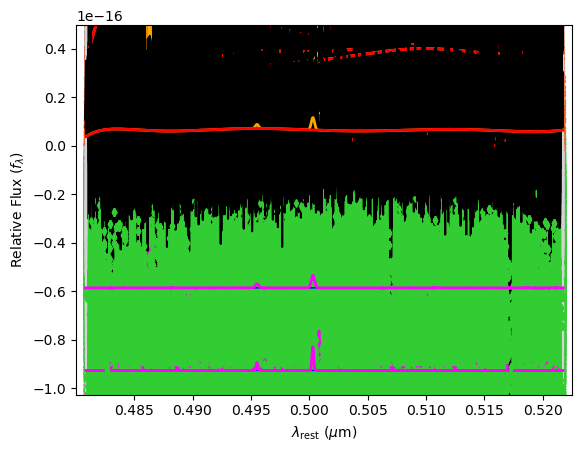

In [21]:
PP_box = []
for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        galaxy = Galaxy_info.spectra[:,i*max(Galaxy_info.col)+j]
        noise = np.ones_like(galaxy)

        template = optimal_templates[:,i,j]
        stars_gas_templates = np.column_stack([template, gas_templates])

        component = [0] + [1]*2
        gas_component=np.array(component) > 0
        moments = [-2, 2]
        ncomp = len(moments)
        tied = [['', ''] for _ in range(ncomp)]

        start = [[velfield[i,j], sigfield[i,j]],
        [velfield[i,j], 50]]

        vlim = lambda x: velfield[i,j] + x*np.array([-100, 100])
        bounds = [[vlim(2), [20, 300]],
                  [vlim(2), [20, 100]]]

        pp = ppxf(stars_gas_templates, galaxy, noise, Galaxy_info.velscale, start,
            plot=1, moments=moments, degree=8, mdegree=-1, component=component, 
            gas_component=gas_component, gas_names=gas_names,
            lam=lam_gal, lam_temp=sps.lam_temp, tied=tied,
            bounds=bounds,
            global_search=True)
        
        PP_box += [pp]

In [22]:
def CK_SpFT(I_index, J_index):
    K_index = I_index*max(Galaxy_info.col)+J_index

    fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(16,12), dpi=300, tight_layout=True)
    gs1 = gridspec.GridSpec(1, 1)
    gs1.update(left=0.05, right=.95, bottom=0.65, top=0.95, hspace=0.0)
    ax1 = plt.subplot(gs1[0])

    gs2 = gridspec.GridSpec(1, 1)
    gs2.update(left=0.05, right=.95, bottom=0.35, top=0.65, hspace=0.0)
    ax2 = plt.subplot(gs2[0])

    gs3 = gridspec.GridSpec(1, 1)
    gs3.update(left=0.05, right=.95, bottom=0.05, top=0.35, hspace=0.0)
    ax3 = plt.subplot(gs3[0])


# -------------------------------------------------------------------------------------------------------------------------------------

    ax1.plot(lam_gal,Galaxy_info.spectra[:,K_index], c='tab:blue', lw=1, alpha=.9, label=galaxy_name+'\npixel:[{:},{:}]'.format(I_index, J_index))
    ax1.plot(lam_gal,Bestfitfield[:,I_index,J_index], '--', c='tab:red', alpha=.9)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'CBP_range'][0]
        RHS = Index_Wave.loc[i,'CBP_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.5, zorder = 0)

    for i in Index_use:
        LHS = Index_Wave.loc[i,'BPC_range'][0]
        RHS = Index_Wave.loc[i,'BPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
    for i in Index_use:
        LHS = Index_Wave.loc[i,'RPC_range'][0]
        RHS = Index_Wave.loc[i,'RPC_range'][1]
        ax1.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax2.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)
        ax3.fill([LHS,RHS,RHS,LHS], [1000,1000,-10000,-1000], color='tab:gray', alpha=.3, zorder = 0)

    for i in [0]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 1, alpha=.9)

    for i in [1]:
        ax1.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 1, alpha=.9)

    ax1.plot(lam_gal,PP_box[K_index].bestfit, '-', lw=.7, c='tab:red')


# -------------------------------------------------------------------------------------------------------------------------------------

    ax2.plot(lam_gal, np.zeros(lam_gal.shape), '-', color='k', lw=.7, alpha=.9, zorder = 0)
    ax2.plot(lam_gal, [np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)]*lam_gal.shape[0], '--', color='tab:blue', lw=1, alpha=.9, zorder = 1)
    MPSig = np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit) + np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)
    MMSig = np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit) - np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)
    ax2.fill([min(lam_gal), max(lam_gal), max(lam_gal), min(lam_gal)], [MPSig, MPSig, MMSig, MMSig], color='tab:gray', alpha=.2,
             label=r'Raange:{:1.3f}$\pm${:1.3f}'.format(np.median(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit), np.std(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)), zorder=1)
    ax2.plot(lam_gal, Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit, '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)

# -------------------------------------------------------------------------------------------------------------------------------------

    ax3.plot(lam_gal, Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index], '+', ms=2, mew=3, color='tab:green', alpha=.9, zorder=2)
    for i in [0]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:orange', zorder = 2, alpha=.9)
    for i in [1]:
        ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,i], color='tab:purple', zorder = 2, alpha=.9)
    
    ax3.plot(lam_gal, PP_box[K_index].gas_bestfit_templates[:,0]+PP_box[K_index].gas_bestfit_templates[:,1, ], lw=.7, color='tab:red', zorder = 2, alpha=.9)


# -------------------------------------------------------------------------------------------------------------------------------------


    ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax2.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax2.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    ax3.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax3.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')
    

    ax1.set_xlim(min(lam_gal), max(lam_gal))
    ax2.set_xlim(min(lam_gal), max(lam_gal))
    ax3.set_xlim(min(lam_gal), max(lam_gal))
    ax1.set_ylim(0,max(Galaxy_info.spectra[:,K_index])*1.1)
    ax2.set_ylim(min(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)*1.2, max(Galaxy_info.spectra[:,K_index]-PP_box[K_index].bestfit)*1.2)
    ax3.set_ylim(min(Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index])*1.2, max(Galaxy_info.spectra[:,K_index]-Bestfitfield[:,I_index,J_index])*1.2)

    ax3.set_xlabel(r'Wave Length $[\AA]$', size=11)
    
    ax1.legend()
    ax2.legend()
    # ax3.legend()

    plt.savefig('./../FitPlot/Fit_02[24Oct22][VCC1588FullFit]/'+galaxy_name+'Fig[{:}]{:}-{:}.pdf'.format(K_index,I_index,J_index), format='pdf', bbox_inches='tight')
    plt.clf()
    plt.close()

    PP_box[K_index] = []

## Fit spectrum plot

In [23]:
# for i in tqdm(range(galaxies.shape[1])):
#     for j in range(galaxies.shape[2]):
#         CK_SpFT(i,j)

# H Beta

In [24]:
Index_Wave

,Index,BPC_range,CBP_range,RPC_range
0,H_beta,"[4827.875, 4847.875]","[4847.875, 4876.625]","[4876.625, 4891.625]"
1,Fe_5015,"[4946.5, 4977.75]","[4977.75, 5054.0]","[5054.0, 5065.25]"
2,Mg_b,"[5142.625, 5161.375]","[5160.125, 5192.625]","[5191.375, 5206.375]"
3,Fe_5270,"[5233.15, 5248.15]","[5245.65, 5285.65]","[5285.65, 5318.15]"
4,Fe_5270_s,"[5233.0, 5250.0]","[5256.5, 5278.5]","[5285.5, 5308.0]"


In [25]:
H_Beta_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
Fe_5015_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
Mg_b_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])

In [26]:
LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])

In [27]:
x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

In [28]:
for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        
        K_index = i*max(Galaxy_info.col)+j
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]


        LP = np.mean([Index_Wave.loc[0,'BPC_range'][0],Index_Wave.loc[0,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[0,'RPC_range'][0],Index_Wave.loc[0,'RPC_range'][1]])
        LCB = Index_Wave.loc[0,'CBP_range'][0]
        RCB = Index_Wave.loc[0,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[0,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[0,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i,j] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i,j] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i,j] = x_wave[:,i,j] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i,j] - y_spectrum[:,i,j]
        for k in range(len(y_SL[:,i,j])):
            NS[k] = NS[k]/y_SL[k,i,j]

        H_Beta_map[i,j] = np.trapz(NS, x_wave[:,i,j]) / (RCB - LCB)

100%|██████████| 23/23 [00:00<00:00, 30.27it/s]


In [29]:
#Fe 5015

LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])

In [30]:
#Fe 5015

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

In [31]:
#Fe 5015

for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        
        K_index = i*max(Galaxy_info.col)+j
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]

        LP = np.mean([Index_Wave.loc[1,'BPC_range'][0],Index_Wave.loc[1,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[1,'RPC_range'][0],Index_Wave.loc[1,'RPC_range'][1]])
        LCB = Index_Wave.loc[1,'CBP_range'][0]
        RCB = Index_Wave.loc[1,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[1,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[1,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i,j] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i,j] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i,j] = x_wave[:,i,j] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i,j] - y_spectrum[:,i,j]
        for k in range(len(y_SL[:,i,j])):
            NS[k] = NS[k]/y_SL[k,i,j]

        Fe_5015_map[i,j] = np.trapz(NS, x_wave[:,i,j]) / (RCB - LCB)

100%|██████████| 23/23 [00:00<00:00, 23.91it/s]


In [32]:
#Mg b

LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])

In [33]:
#Mg b

x_wave = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_spectrum = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))
y_SL = np.ndarray(shape=(len(lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]),Galaxy_info.cube.shape[1],Galaxy_info.cube.shape[2]))

In [34]:
#Mg b

for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        
        K_index = i*max(Galaxy_info.col)+j
        spectrum_fit_NEL = PP_box[K_index].bestfit
        for k in [0,1]:
            spectrum_fit_NEL = spectrum_fit_NEL - PP_box[K_index].gas_bestfit_templates[:,k]


        LP = np.mean([Index_Wave.loc[2,'BPC_range'][0],Index_Wave.loc[2,'BPC_range'][1]])
        RP = np.mean([Index_Wave.loc[2,'RPC_range'][0],Index_Wave.loc[2,'RPC_range'][1]])
        LCB = Index_Wave.loc[2,'CBP_range'][0]
        RCB = Index_Wave.loc[2,'CBP_range'][1]
        LPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'BPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'BPC_range'][1])) ])
        RPV = np.mean(spectrum_fit_NEL[ np.where((lam_gal>Index_Wave.loc[2,'RPC_range'][0]) & (lam_gal<Index_Wave.loc[2,'RPC_range'][1])) ])

        # H_Beta_map[i,j] = np.trapz(Bestfitfield[:,i,j][ np.where((lam_gal>LP) & (lam_gal<RP)) ], lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]) - np.trapz([LPV,RPV],[LP,RP])

        x_wave[:,i,j] = lam_gal[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_spectrum[:,i,j] = spectrum_fit_NEL[ np.where((lam_gal>LP) & (lam_gal<RP)) ]
        y_SL[:,i,j] = x_wave[:,i,j] * ((RPV-LPV)/(RP-LP)) - LP * ((RPV-LPV)/(RP-LP)) + LPV

        NS = y_SL[:,i,j] - y_spectrum[:,i,j]
        for k in range(len(y_SL[:,i,j])):
            NS[k] = NS[k]/y_SL[k,i,j]

        Mg_b_map[i,j] = np.trapz(NS, x_wave[:,i,j]) / (RCB - LCB)

100%|██████████| 23/23 [00:00<00:00, 32.63it/s]


C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\846896561.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\846896561.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\846896561.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Local

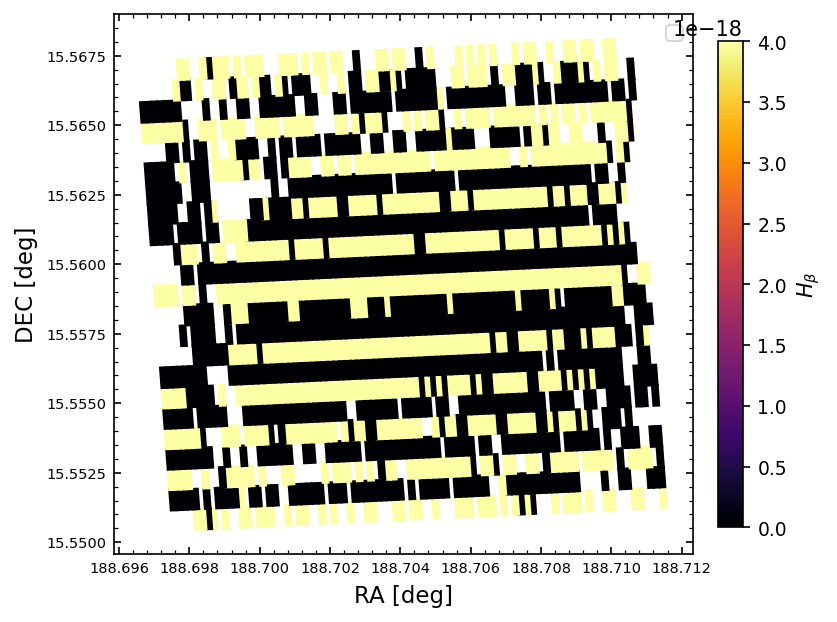

In [35]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = 0
RHS = 4e-18

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(H_Beta_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $')

plt.show()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\4223764271.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\4223764271.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\4223764271.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Lo

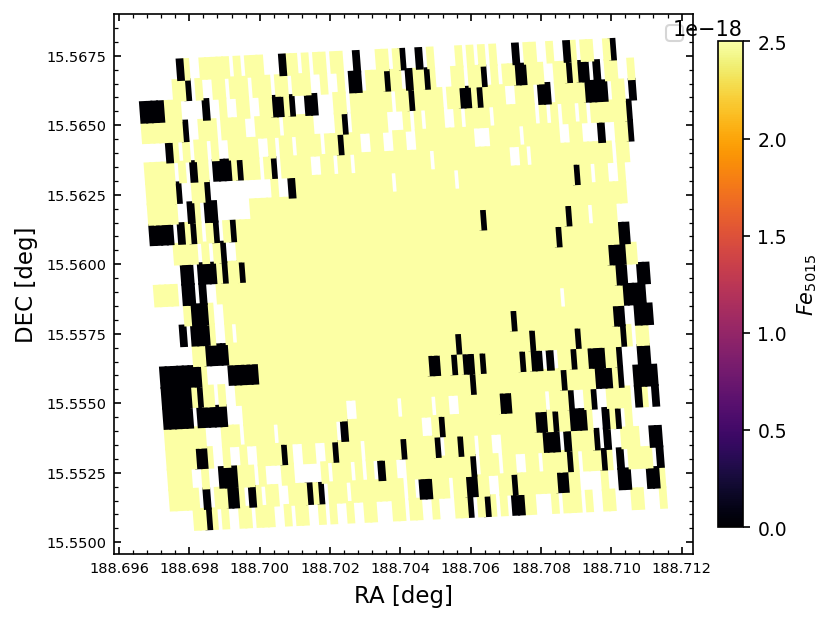

In [36]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = 0
RHS = 2.5e-18

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(Fe_5015_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ Fe_{5015} $')

plt.show()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\2109862224.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\2109862224.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\2109862224.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Lo

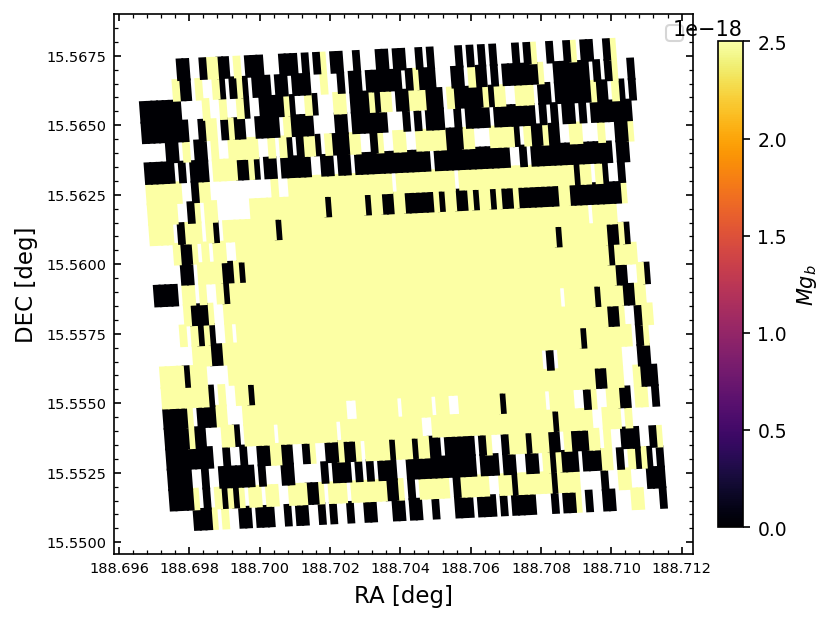

In [37]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = 0
RHS = 2.5e-18

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(Mg_b_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ Mg_{b} $')

plt.show()

# plt.savefig('./', format='pdf', bbox_inches='tight')

# Emission map

In [38]:
H_Beta_EL_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
H_Beta_EL_AN_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
O_5007_EL_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])
O_5007_EL_AN_map = np.ndarray(shape=Galaxy_info.cube.shape[1:3])

In [39]:
names = ['Hbeta', '[OIII]5007_d']
c_kms = 299792.458  # speed of light in km/s

In [40]:
for i in tqdm(range(galaxies.shape[1])):
    for j in range(galaxies.shape[2]):
        # if(i == 11 and j ==43):
            K_index = i*max(Galaxy_info.col)+j
            rms = robust_sigma(Galaxy_info.spectra[:,i*max(Galaxy_info.col)+j] - PP_box[K_index].bestfit, zero=1)
            for p, name in enumerate(names):
                kk = gas_names == name + '_(1)'   # Extract first gas kinematic component
                print(kk)
                dlam = line_wave[kk]*Galaxy_info.velscale/c_kms   # Angstrom per pixel at line wavelength (dlam/lam = dv/c)
                flux = (PP_box[K_index].gas_flux[kk]*dlam)[0]  # Convert to ergs/(cm^2 s)
                an = np.max(PP_box[K_index].gas_bestfit_templates[:, kk])/rms
                print(f"{name:12s} - Amplitude/Noise: {an:6.4g}; gas flux: {flux:6.0f} ergs/(cm^2 s)")
                if(kk[0]):
                    H_Beta_EL_map[i,j] = flux
                    H_Beta_EL_AN_map[i,j] = an
                if(kk[1]):
                    O_5007_EL_map[i,j] = flux
                    O_5007_EL_AN_map[i,j] = an

 13%|█▎        | 3/23 [00:00<00:00, 21.83it/s]

[ True False]
Hbeta        - Amplitude/Noise: 0.6777; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:     -0; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:     -0; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise: 0.4332; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  1.332; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  0.462; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  2.508; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:     -0; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise: 0.9555; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  0.712; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  1.876; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise: 0.2087; gas flux:  

 39%|███▉      | 9/23 [00:00<00:00, 26.30it/s]

[ True False]
Hbeta        - Amplitude/Noise: 0.9828; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  1.097; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  2.247; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  0.521; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise: 0.5104; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:     -0; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  1.142; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  1.166; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:     -0; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  2.163; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  4.106; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise: 0.6791; gas flux:  

 65%|██████▌   | 15/23 [00:00<00:00, 28.03it/s]

[ True False]
Hbeta        - Amplitude/Noise:  2.261; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  1.334; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise: 0.7171; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise: 0.2486; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise: 0.6608; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:      0; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:      0; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise: 0.9189; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:   1.14; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise: 0.4383; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:   1.05; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  0.115; gas flux:  

100%|██████████| 23/23 [00:00<00:00, 27.77it/s]

[ True False]
Hbeta        - Amplitude/Noise:  7.287; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  2.015; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  4.075; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise: 0.9375; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:   2.69; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  1.087; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  2.658; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:     -0; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise:  1.878; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:     -0; gas flux:      0 ergs/(cm^2 s)
[ True False]
Hbeta        - Amplitude/Noise: 0.3706; gas flux:      0 ergs/(cm^2 s)
[False  True]
[OIII]5007_d - Amplitude/Noise:  1.359; gas flux:  

H beta

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\4070638744.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\4070638744.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\4070638744.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Lo

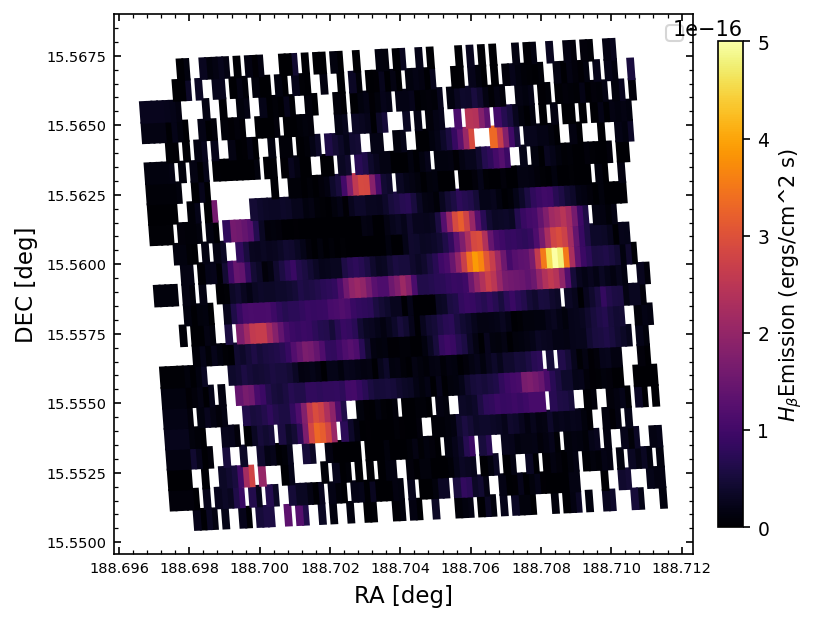

In [41]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = -0
RHS = 5e-16

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(H_Beta_EL_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $Emission (ergs/cm^2 s)')

plt.show()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\585333836.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\585333836.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\585333836.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Local

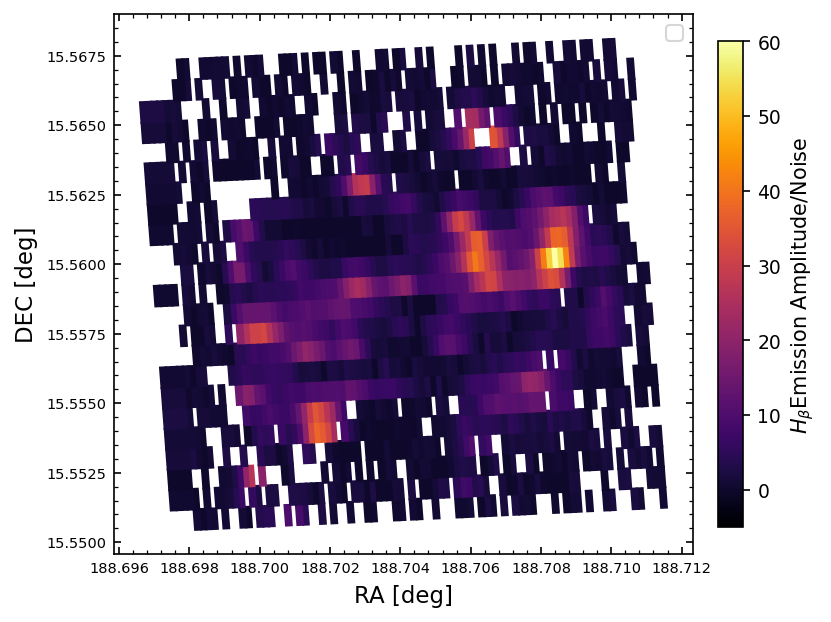

In [42]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = -5
RHS = 60

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(H_Beta_EL_AN_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $Emission Amplitude/Noise')

plt.show()

# plt.savefig('./', format='pdf', bbox_inches='tight')

O_5007

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\1580059221.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\1580059221.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\1580059221.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Lo

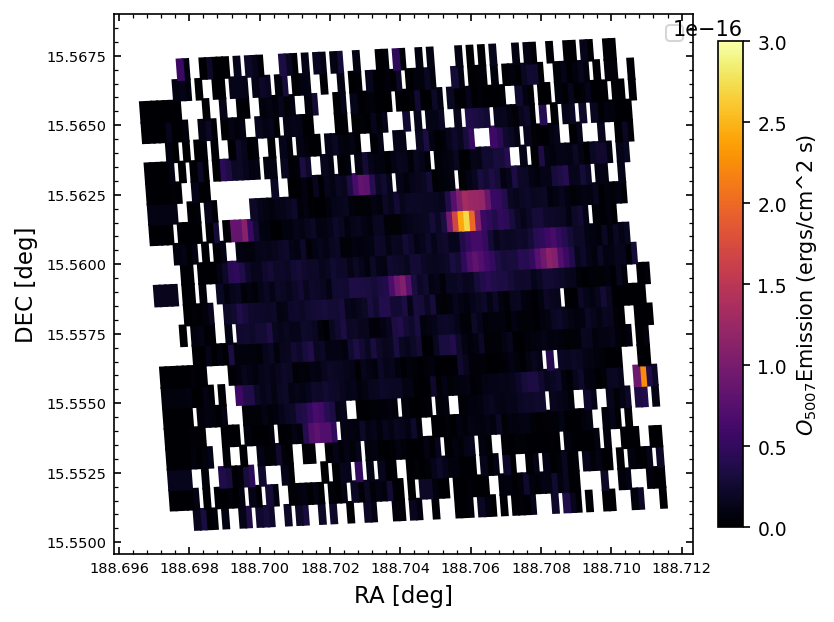

In [43]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = 0
RHS = 3e-16

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(O_5007_EL_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ O_{5007} $Emission (ergs/cm^2 s)')

plt.show()

# plt.savefig('./', format='pdf', bbox_inches='tight')

C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\3032556443.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(gs1[0])
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\3032556443.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm1 = plt.cm.get_cmap('inferno')
C:\Users\VacEn-WenJin\AppData\Local\Temp\ipykernel_21372\3032556443.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
C:\Users\VacEn-WenJin\AppData\Lo

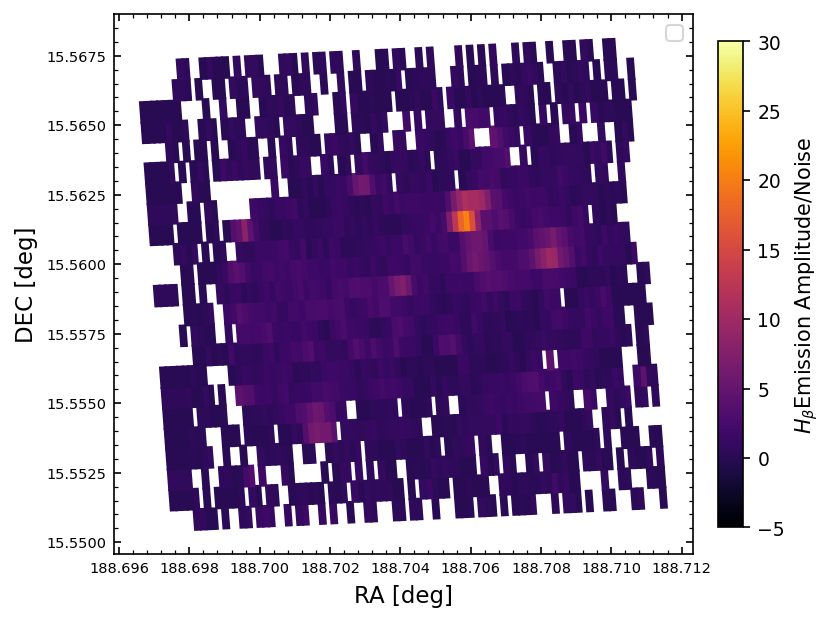

In [44]:
fig, ax = plt.subplots(1, 1, facecolor='white', figsize=(6,4), dpi=150, tight_layout=True)
gs1 = gridspec.GridSpec(1, 1)
gs1.update(left=0.05, right=.75, bottom=0.05, top=0.95, hspace=0.0)
ax1 = plt.subplot(gs1[0])

LHS = -5
RHS = 30

LHS_v = -20
RHS_v = 100

cm1 = plt.cm.get_cmap('inferno')
norm = mpl.colors.Normalize(vmin=LHS, vmax=RHS)
# norm = mpl.colors.Normalize()
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.get_cmap('inferno'))
cmap.set_array([])

cb1 = plt.colorbar(cmap,fraction=0.04,pad=0.04,shrink=0.9)
cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'')

for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        if(velfield[i,j]>LHS_v and velfield[i,j]<RHS_v):
            Ori_ra  = Galaxy_info.CRVAL1 + ((i-1)*Galaxy_info.CD1_2) + ((j-1)*Galaxy_info.CD1_1)
            Ori_dec = Galaxy_info.CRVAL2 + ((i-1)*Galaxy_info.CD2_2) + ((j-1)*Galaxy_info.CD2_1)
            ax1.fill([Ori_ra,  Ori_ra+Galaxy_info.CD1_2,  Ori_ra+Galaxy_info.CD1_2+Galaxy_info.CD1_1,  Ori_ra+Galaxy_info.CD1_1],
                    [Ori_dec, Ori_dec+Galaxy_info.CD2_2, Ori_dec+Galaxy_info.CD2_2+Galaxy_info.CD2_1, Ori_dec+Galaxy_info.CD2_1],
                    color=cmap.to_rgba(O_5007_EL_AN_map[i,j]))



ax1.xaxis.set_minor_locator(AutoMinorLocator(5))
ax1.yaxis.set_minor_locator(AutoMinorLocator(5))
ax1.tick_params(axis='both', which='both', labelsize='x-small', right=True, top=True, direction='in')


ax1.set_xlabel(r'RA [deg]', size=11)
ax1.set_ylabel(r'DEC [deg]', size=11)

ax1.legend()

cb1.ax.tick_params(labelsize=9)
cb1.set_label(label=r'$ H_{\beta} $Emission Amplitude/Noise')

plt.show()

# plt.savefig('./', format='pdf', bbox_inches='tight')

# Data Collection

In [45]:
signal = np.median(Galaxy_info.spectra[ np.where((lam_gal>5075) & (lam_gal<5125)) ] , 0)
noise = np.std( Galaxy_info.spectra[ np.where((lam_gal>5075) & (lam_gal<5125)) ], 0)

In [46]:
VNB_Sol = pd.DataFrame({'H_beta_EL_value':[],'H_beta_EL_ANR':[],
                        'O_3_5007_EL_value':[],'O_3_5007_EL_ANR':[],
                        'Component_Sol':[],
                        'H_beta_SI':[],'Mg_b_SI':[],'Fe_5015_SI':[],
                        'R':[],'SNR':[],'K_index':[]})

In [47]:
def TB_reindex(TB_now):
    TB_now = TB_now.reset_index()
    TB_now = TB_now.drop(columns='index')
    return TB_now

In [48]:
for i in range(Galaxy_info.cube.shape[1]):
    for j in range(Galaxy_info.cube.shape[2]):
        K_index = i*max(Galaxy_info.col)+j


        Ori_ra  = Galaxy_info.CRVAL1 + ((i)*Galaxy_info.CD1_2) + ((j)*Galaxy_info.CD1_1) + (Galaxy_info.CD1_2+Galaxy_info.CD1_1)/2
        Ori_dec = Galaxy_info.CRVAL2 + ((i)*Galaxy_info.CD2_2) + ((j)*Galaxy_info.CD2_1) + (Galaxy_info.CD2_2+Galaxy_info.CD2_1)/2
        O_x = (Galaxy_info.CRVAL1 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD1_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD1_1))/2)
        O_y = (Galaxy_info.CRVAL2 + (((Galaxy_info.cube.shape[1])*Galaxy_info.CD2_2) + ((Galaxy_info.cube.shape[2])*Galaxy_info.CD2_1))/2)
        R = np.sqrt((Ori_ra - O_x)**2 + (Ori_dec - O_y)**2)

        VNB_Sol_lim = pd.DataFrame({'H_beta_EL_value':[H_Beta_EL_map[i,j]],'H_beta_EL_ANR':[H_Beta_EL_AN_map[i,j]],
                        'O_3_5007_EL_value':[O_5007_EL_map[i,j]],'O_3_5007_EL_ANR':[O_5007_EL_AN_map[i,j]],
                        'Component_Sol':[PP_box[K_index].sol],
                        'H_beta_SI':[H_Beta_map[i,j]],'Mg_b_SI':[Fe_5015_map[i,j]],'Fe_5015_SI':[Mg_b_map[i,j]],
                        'R':[R],'SNR':[signal[K_index]/noise[K_index]],'K_index':[[K_index]]})
        
        VNB_Sol = TB_reindex(pd.concat([VNB_Sol, VNB_Sol_lim]))

In [49]:
VNB_Sol.to_csv('./../FitData/Fit_DS_02[24Nov14][VCC1588]/'+galaxy_name+'_P2P_SFR.csv')